In [35]:
import pandas as pd
import numpy as np
from operator import itemgetter
from math import radians, cos, sin, asin, sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, wilcoxon

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.anova import anova_lm

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [36]:
df = pd.read_excel('Data_Train.xlsx')
df_cities = pd.read_csv('Indian Cities Database.csv')
holidays = pd.read_csv('2019.csv')

In [37]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,Null,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,Null,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,Null,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,Null,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,Null,13302


In [38]:
df['Dep_Date'] = pd.to_datetime(df['Date_of_Journey'] + ' ' + df['Dep_Time'])

In [39]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], infer_datetime_format=True)

In [40]:
df['Dep_Day'] = df['Date_of_Journey'].dt.day
df['Dep_Day'] = df['Dep_Day'].astype('int64')

df['Dep_Week'] = df['Date_of_Journey'].dt.isocalendar().week
df['Dep_Week'] = df['Dep_Week'].astype('int64')

df['Dep_Month'] = df['Date_of_Journey'].dt.month
df['Dep_Month'] = df['Dep_Month'].astype('int64')

df['Dep_Quarter'] = df['Date_of_Journey'].dt.quarter
df['Dep_Quarter'] = df['Dep_Quarter'].astype('int64')

df['Dep_WeekName'] = df['Date_of_Journey'].dt.day_name()

df['Dep_Season'] = df['Dep_Month']%12 // 3 + 1
df['Dep_Season'] = df['Dep_Season'].astype('int64')

df['Is_Weekday_Dep'] = np.where(df['Dep_WeekName'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 1, 0)
df['Is_Weekday_Dep'] = df['Is_Weekday_Dep'].astype('int64')

df['Is_Weekend_Dep'] = np.where(df['Dep_WeekName'].isin(['Saturday', 'Sunday']), 1, 0)
df['Is_Weekend_Dep'] = df['Is_Weekend_Dep'].astype('int64')

In [41]:
df['Duration_Hour'] = df['Duration'].str.split(' ').str[0]
df['Duration_Minute'] = df['Duration'].str.split(' ').str[1]

In [42]:
df['Duration_Hour']= df['Duration_Hour'].str.split('h').str[0]
df['Duration_Minute'] = df['Duration_Minute'].str.split('m').str[0]

In [43]:
df['Duration_Minute'] = df['Duration_Minute'].fillna(0)
df['Duration_Hour'] = df['Duration_Hour'].fillna(0)

In [44]:
pd.set_option('display.max_columns', 22)
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Dep_Date,Dep_Day,Dep_Week,Dep_Month,Dep_Quarter,Dep_WeekName,Dep_Season,Is_Weekday_Dep,Is_Weekend_Dep,Duration_Hour,Duration_Minute
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,Null,3897,2019-03-24 22:20:00,24,12,3,1,Sunday,2,0,1,2,50
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,Null,7662,2019-01-05 05:50:00,1,18,5,2,Wednesday,2,1,0,7,25
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,Null,13882,2019-09-06 09:25:00,9,23,6,2,Sunday,3,0,1,19,0
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,Null,6218,2019-12-05 18:05:00,12,19,5,2,Sunday,2,0,1,5,25
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,Null,13302,2019-01-03 16:50:00,1,9,3,1,Friday,2,1,0,4,45


In [45]:
df['Duration'] = df['Duration'].str.replace("h", '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
df['Duration'] = df['Duration'].astype('int64')

In [46]:
df['Dep_Time'] = df['Dep_Time'].str.split(':')

df['Dep_Time_Hour'] = df['Dep_Time'].str[0]
df['Dep_Time_Hour'] = df['Dep_Time_Hour'].astype('int64')

df['Dep_Time_Minute'] = df['Dep_Time'].str[1]
df['Dep_Time_Minute'] = df['Dep_Time_Minute'].astype('int64')

In [47]:
df['Arrival_Time'] = df['Arrival_Time'].str.split(' ')

df['Arrival_Time'] = df['Arrival_Time'].str[0]
df['Arrival_Time_'] = df['Arrival_Time'].str.split(':')

df['Arrival_Time_Hour'] = df['Arrival_Time_'].str[0]
df['Arrival_Time_Hour'] = df['Arrival_Time_Hour'].astype('int64')

df['Arrival_Time_Minute'] = df['Arrival_Time_'].str[1]
df['Arrival_Time_Minute'] = df['Arrival_Time_Minute'].astype('int64')

In [48]:
df['Arrival_Date'] = df['Dep_Date'] + pd.TimedeltaIndex(df['Duration'], unit='minutes')

In [49]:
df['Arr_Day'] = df['Arrival_Date'].dt.day
df['Arr_Day'] = df['Arr_Day'].astype('int64')

df['Arr_Week'] = df['Arrival_Date'].dt.isocalendar().week
df['Arr_Week'] = df['Arr_Week'].astype('int64')

df['Arr_Month'] = df['Arrival_Date'].dt.month
df['Arr_Month'] = df['Arr_Month'].astype('int64')

df['Arr_Quarter'] = df['Arrival_Date'].dt.quarter
df['Arr_Quarter'] = df['Arr_Quarter'].astype('int64')

df['Arr_WeekName'] = df['Arrival_Date'].dt.day_name()

df['Arr_Season'] = df['Arr_Month']%12 // 3 + 1
df['Arr_Season'] = df['Arr_Season'].astype('int64')

df['Is_Weekday_Arr'] = np.where(df['Arr_WeekName'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 1, 0)
df['Is_Weekday_Arr'] = df['Is_Weekday_Arr'].astype('int64')

df['Is_Weekend_Arr'] = np.where(df['Arr_WeekName'].isin(['Saturday', 'Sunday']), 1, 0)
df['Is_Weekend_Arr'] = df['Is_Weekend_Arr'].astype('int64')

In [50]:
def time_of_day(n):
    if n in range(4,8):
        return 'Early Morning'
    elif n in range(8,12):
        return 'Morning'
    elif n in range(12,18):
        return 'Afternoon'
    elif n in range(18,21):
        return 'Evening'
    elif n in range(21,25) or n==0:
        return 'Night'
    elif n in range(1,4):
        return 'Late Night'
    
df['Dep_Type_of_Day'] = df['Dep_Time_Hour'].apply(lambda x: time_of_day(x))
df['Arr_Type_of_Day'] = df['Arrival_Time_Hour'].apply(lambda x: time_of_day(x))

In [51]:
df['Flight_Dep_Type'] = df['Airline'] + '_' + df['Dep_Type_of_Day']
df['Flight_Arr_Type'] = df['Airline'] + '_' + df['Arr_Type_of_Day']

In [52]:
df['Route'] = df['Route'].str.split('→')
df['City1'] = df['Route'].str[0]
df['City2'] = df['Route'].str[1]
df['City3'] = df['Route'].str[2]
df['City4'] = df['Route'].str[3]
df['City5'] = df['Route'].str[4]
df['City6'] = df['Route'].str[5]

In [53]:
df['City3'].fillna('None', axis=0, inplace=True)
df['City4'].fillna('None', axis=0, inplace=True)
df['City5'].fillna('None', axis=0, inplace=True)
df['City6'].fillna('None', axis=0, inplace=True)

In [54]:
df['Total_Stops'] = df['Total_Stops'].replace({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4})

In [55]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,...,Is_Weekend_Arr,Dep_Type_of_Day,Arr_Type_of_Day,Flight_Dep_Type,Flight_Arr_Type,City1,City2,City3,City4,City5,City6
0,IndiGo,2019-03-24,Banglore,New Delhi,"[BLR , DEL]","[22, 20]",01:10,170,0.0,Null,3897,...,0,Night,Late Night,IndiGo_Night,IndiGo_Late Night,BLR,DEL,None,None,None,None
1,Air India,2019-05-01,Kolkata,Banglore,"[CCU , IXR , BBI , BLR]","[05, 50]",13:15,445,2.0,Null,7662,...,1,Early Morning,Afternoon,Air India_Early Morning,Air India_Afternoon,CCU,IXR,BBI,BLR,None,None
2,Jet Airways,2019-06-09,Delhi,Cochin,"[DEL , LKO , BOM , COK]","[09, 25]",04:25,1140,2.0,Null,13882,...,1,Morning,Early Morning,Jet Airways_Morning,Jet Airways_Early Morning,DEL,LKO,BOM,COK,None,None
3,IndiGo,2019-05-12,Kolkata,Banglore,"[CCU , NAG , BLR]","[18, 05]",23:30,325,1.0,Null,6218,...,0,Evening,Night,IndiGo_Evening,IndiGo_Night,CCU,NAG,BLR,None,None,None
4,IndiGo,2019-03-01,Banglore,New Delhi,"[BLR , NAG , DEL]","[16, 50]",21:35,285,1.0,Null,13302,...,0,Afternoon,Night,IndiGo_Afternoon,IndiGo_Night,BLR,NAG,DEL,None,None,None


In [56]:
df.drop(['Dep_Time', 'Arrival_Time', 'Arrival_Time_'], axis=1, inplace=True)

In [57]:
df_cities['Source'] = df_cities['City'].copy()
df_cities['Source'] = df_cities['Source'].replace({'Bengaluru': 'Banglore', 'Calicut': 'Kolkata', 'Kochi': 'Cochin'})

In [58]:
merged_df = df.merge(df_cities, on='Source', how='left')

In [59]:
merged_df.drop(['State', 'iso2', 'country'], axis=1, inplace=True)

In [60]:
merged_df.rename(columns={'Lat': 'Lat_Source', 'Long': 'Long_Source'}, inplace=True)

In [61]:
df_cities['Destination'] = df_cities['City'].copy()
df_cities['Destination'] = df_cities['Destination'].replace({'Bengaluru': 'Banglore', 'Calicut': 'Kolkata', 'Kochi': 'Cochin'})

In [62]:
merged_df = merged_df.merge(df_cities, on='Destination', how='left')

In [63]:
merged_df.drop(['State', 'iso2', 'country'], axis=1, inplace=True)

In [64]:
merged_df.rename(columns={'Lat': 'Lat_Destination', 'Long': 'Long_Destination'}, inplace=True)

In [65]:
merged_df.drop(['City_x', 'City_y', 'Source_y'], axis=1, inplace=True)

In [66]:
merged_df.rename(columns={'Source_x': 'Source'}, inplace=True)

In [67]:
def distance_trip(p_lat, d_lat, p_lon, d_lon):
    p_lon = radians(p_lon)
    d_lon = radians(d_lon)
    p_lat = radians(p_lat)
    d_lat = radians(d_lat)
    
    dlon = d_lon - p_lon
    dlat = d_lat - p_lat
    a = sin(dlat / 2)**2 + cos(p_lat) * cos(d_lat) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    r = 6371

    return(c * r)

In [68]:
merged_df['Distance'] = merged_df.apply(lambda x: distance_trip(x['Lat_Source'],
                                                         x['Lat_Destination'],
                                                         x['Long_Source'],
                                                         x['Long_Destination']), axis=1)

In [69]:
holidays.rename(columns={'date': 'Date_of_Journey'}, inplace=True)

In [70]:
holidays['Date_of_Journey'] = pd.to_datetime(holidays['Date_of_Journey'], infer_datetime_format=True)

In [71]:
merged_df = merged_df.merge(holidays, on='Date_of_Journey', how='left')

In [72]:
merged_df['holiday'].fillna('No Holiday', inplace=True)

In [73]:
merged_df['holiday_type'].fillna('None', inplace=True)

In [74]:
merged_df['Total_Stops'].isnull().sum()

1

In [75]:
merged_df.drop(merged_df.loc[merged_df['Total_Stops'].isnull(), :].index, axis=0, inplace=True)

In [76]:
merged_df['Total_Stops'] = merged_df['Total_Stops'].astype('int64')

In [77]:
merged_df.drop('day', axis=1, inplace=True)

In [78]:
pd.set_option('display.max_columns', 69)
merged_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Dep_Date,Dep_Day,Dep_Week,Dep_Month,Dep_Quarter,Dep_WeekName,Dep_Season,Is_Weekday_Dep,Is_Weekend_Dep,Duration_Hour,Duration_Minute,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Arrival_Date,Arr_Day,Arr_Week,Arr_Month,Arr_Quarter,Arr_WeekName,Arr_Season,Is_Weekday_Arr,Is_Weekend_Arr,Dep_Type_of_Day,Arr_Type_of_Day,Flight_Dep_Type,Flight_Arr_Type,City1,City2,City3,City4,City5,City6,Lat_Source,Long_Source,Lat_Destination,Long_Destination,Distance,holiday,holiday_type
0,IndiGo,2019-03-24,Banglore,New Delhi,"[BLR , DEL]",170,0,Null,3897,2019-03-24 22:20:00,24,12,3,1,Sunday,2,0,1,2,50,22,20,1,10,2019-03-25 01:10:00,25,13,3,1,Monday,2,1,0,Night,Late Night,IndiGo_Night,IndiGo_Late Night,BLR,DEL,None,None,None,None,12.977063,77.587106,28.600000,77.200000,1737.653224,No Holiday,None
1,Air India,2019-05-01,Kolkata,Banglore,"[CCU , IXR , BBI , BLR]",445,2,Null,7662,2019-01-05 05:50:00,1,18,5,2,Wednesday,2,1,0,7,25,5,50,13,15,2019-01-05 13:15:00,5,1,1,1,Saturday,1,0,1,Early Morning,Afternoon,Air India_Early Morning,Air India_Afternoon,CCU,IXR,BBI,BLR,None,None,11.248016,75.780402,12.977063,77.587106,274.851302,No Holiday,None
2,Jet Airways,2019-06-09,Delhi,Cochin,"[DEL , LKO , BOM , COK]",1140,2,Null,13882,2019-09-06 09:25:00,9,23,6,2,Sunday,3,0,1,19,0,9,25,4,25,2019-09-07 04:25:00,7,36,9,3,Saturday,4,0,1,Morning,Early Morning,Jet Airways_Morning,Jet Airways_Early Morning,DEL,LKO,BOM,COK,None,None,28.651952,77.231495,9.947743,76.253802,2082.311722,No Holiday,None
3,IndiGo,2019-05-12,Kolkata,Banglore,"[CCU , NAG , BLR]",325,1,Null,6218,2019-12-05 18:05:00,12,19,5,2,Sunday,2,0,1,5,25,18,5,23,30,2019-12-05 23:30:00,5,49,12,4,Thursday,1,1,0,Evening,Night,IndiGo_Evening,IndiGo_Night,CCU,NAG,BLR,None,None,None,11.248016,75.780402,12.977063,77.587106,274.851302,No Holiday,None
4,IndiGo,2019-03-01,Banglore,New Delhi,"[BLR , NAG , DEL]",285,1,Null,13302,2019-01-03 16:50:00,1,9,3,1,Friday,2,1,0,4,45,16,50,21,35,2019-01-03 21:35:00,3,1,1,1,Thursday,1,1,0,Afternoon,Night,IndiGo_Afternoon,IndiGo_Night,BLR,NAG,DEL,None,None,None,12.977063,77.587106,28.600000,77.200000,1737.653224,Swami Dayananda Saraswati Jayanti (R),Restricted


In [79]:
merged_df[['Dep_Day', 'Dep_Week', 'Dep_Month', 'Dep_Quarter', 'Dep_Time_Hour', 'Dep_Time_Minute']].describe()

,Dep_Day,Dep_Week,Dep_Month,Dep_Quarter,Dep_Time_Hour,Dep_Time_Minute
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000
mean,13.509081,18.413687,4.708575,1.744992,12.491013,24.409287
std,8.479363,5.227373,1.164408,0.435886,5.748820,18.767801
min,1.000000,9.000000,3.000000,1.000000,0.000000,0.000000
25%,6.000000,13.000000,3.000000,1.000000,8.000000,5.000000
50%,12.000000,20.000000,5.000000,2.000000,11.000000,25.000000
75%,21.000000,23.000000,6.000000,2.000000,18.000000,40.000000
max,27.000000,26.000000,6.000000,2.000000,23.000000,55.000000


In [80]:
merged_df[['Arr_Day', 'Arr_Week', 'Arr_Month', 'Arr_Quarter', 'Arrival_Time_Hour', 'Arrival_Time_Minute']].describe()

,Arr_Day,Arr_Week,Arr_Month,Arr_Quarter,Arrival_Time_Hour,Arrival_Time_Minute
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000
mean,13.093615,21.982307,5.534731,2.003183,13.349186,24.690601
std,8.804551,12.740295,2.987626,0.893123,6.859317,16.506808
min,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5.000000,12.000000,3.000000,1.000000,8.000000,10.000000
50%,7.000000,21.000000,5.000000,2.000000,14.000000,25.000000
75%,21.000000,26.000000,6.000000,2.000000,19.000000,35.000000
max,29.000000,49.000000,12.000000,4.000000,23.000000,55.000000


In [81]:
def encode_cyclic_f(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [82]:
merged_df = encode_cyclic_f(merged_df, 'Dep_Month', 6)
merged_df = encode_cyclic_f(merged_df, 'Dep_Day', 27)
merged_df = encode_cyclic_f(merged_df, 'Dep_Week', 26)
merged_df = encode_cyclic_f(merged_df, 'Dep_Quarter', 2)
merged_df = encode_cyclic_f(merged_df, 'Dep_Time_Hour', 23)
merged_df = encode_cyclic_f(merged_df, 'Dep_Time_Minute', 55)

In [83]:
merged_df = encode_cyclic_f(merged_df, 'Arr_Month', 12)
merged_df = encode_cyclic_f(merged_df, 'Arr_Day', 29)
merged_df = encode_cyclic_f(merged_df, 'Arr_Week', 49)
merged_df = encode_cyclic_f(merged_df, 'Arr_Quarter', 4)
merged_df = encode_cyclic_f(merged_df, 'Arrival_Time_Hour', 23)
merged_df = encode_cyclic_f(merged_df, 'Arrival_Time_Minute', 55)

In [84]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 74 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Airline                  10682 non-null  object        
 1   Date_of_Journey          10682 non-null  datetime64[ns]
 2   Source                   10682 non-null  object        
 3   Destination              10682 non-null  object        
 4   Route                    10682 non-null  object        
 5   Duration                 10682 non-null  int64         
 6   Total_Stops              10682 non-null  int64         
 7   Additional_Info          10682 non-null  object        
 8   Price                    10682 non-null  int64         
 9   Dep_Date                 10682 non-null  datetime64[ns]
 10  Dep_Day                  10682 non-null  int64         
 11  Dep_Week                 10682 non-null  int64         
 12  Dep_Month                10682 n

In [85]:
lm = ols('Price ~ Airline', data=merged_df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     676.6
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:59:44   Log-Likelihood:            -1.0245e+05
No. Observations:               10682   AIC:                         2.049e+05
Df Residuals:                   10670   BIC:                         2.050e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

Our model explains 41.1% of the change in our Price variable. Large F-Statistics values confirms that our Independent Variable is significant.

In [86]:
shapiro(merged_df['Price'])

ShapiroResult(statistic=0.8955820798873901, pvalue=0.0)

In [87]:
wilcoxon(merged_df['Price'])

WilcoxonResult(statistic=0.0, pvalue=0.0)

In [88]:
airlines = df['Airline'].unique()
dataset = [merged_df.loc[merged_df['Airline'] == airline, 'Price'] for airline in airlines]
table = pd.DataFrame(columns = ['airline 1', 'airline 2', 'degrees of freedom', 'T-test statistic', 'p value'])

for i in range(len(airlines)):
    for j in range(i + 1, len(airlines)):
        tstat, pvalue, degrees = ttest_ind(dataset[i], dataset[j], usevar = 'unequal', alternative = 'two-sided')
        table = table.append({
            'airline 1': airlines[i],
            'airline 2': airlines[j],
            'degrees of freedom': degrees,
            'T-test statistic': tstat,
            'p value': pvalue
        }, ignore_index = True)
        
table

,airline 1,airline 2,degrees of freedom,T-test statistic,p value
0,IndiGo,Air India,2708.994036,-37.232282,0.0
1,IndiGo,Jet Airways,5899.945305,-70.313384,0.0
2,IndiGo,SpiceJet,1824.516174,16.338113,0.0
3,IndiGo,Multiple carriers,1719.441906,-44.07478,0.0
4,IndiGo,GoAir,219.338649,-0.934836,0.350901
...,...,...,...,...,...
61,Vistara Premium economy,Multiple carriers Premium economy,2.330556,-1.404292,0.278672
62,Vistara Premium economy,Trujet,NaN,NaN,NaN
63,Jet Airways Business,Multiple carriers Premium economy,5.100256,9.805633,0.000168
64,Jet Airways Business,Trujet,NaN,NaN,NaN


In [89]:
table[table['p value']>0.05]

,airline 1,airline 2,degrees of freedom,T-test statistic,p value
4,IndiGo,GoAir,219.338649,-0.934836,0.350901
6,IndiGo,Air Asia,450.575416,0.672641,0.501521
7,IndiGo,Vistara Premium economy,2.003527,-1.952936,0.189837
17,Air India,Vistara Premium economy,2.012294,0.385632,0.736722
26,Jet Airways,Vistara Premium economy,2.006659,1.591817,0.252015
28,Jet Airways,Multiple carriers Premium economy,12.503808,0.467766,0.648
34,SpiceJet,Vistara Premium economy,2.005911,-2.745134,0.110679
41,Multiple carriers,Vistara Premium economy,2.01638,1.150416,0.368133
43,Multiple carriers,Multiple carriers Premium economy,13.256044,-1.057164,0.309322
46,GoAir,Air Asia,324.538031,1.204292,0.229354


In [90]:
table[table['p value']<0.05]

,airline 1,airline 2,degrees of freedom,T-test statistic,p value
0,IndiGo,Air India,2708.994036,-37.232282,0.0
1,IndiGo,Jet Airways,5899.945305,-70.313384,0.0
2,IndiGo,SpiceJet,1824.516174,16.338113,0.0
3,IndiGo,Multiple carriers,1719.441906,-44.07478,0.0
5,IndiGo,Vistara,619.249598,-14.924694,0.0
8,IndiGo,Jet Airways Business,5.001101,-11.060052,0.000105
9,IndiGo,Multiple carriers Premium economy,12.265659,-11.997405,0.0
11,Air India,Jet Airways,3670.793872,-17.54504,0.0
12,Air India,SpiceJet,2566.484626,46.476197,0.0
13,Air India,Multiple carriers,2645.043452,-9.061934,0.0


In [91]:
lm = ols('Price ~ Dep_Type_of_Day + Arr_Type_of_Day', data=merged_df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     72.63
Date:                Fri, 16 Dec 2022   Prob (F-statistic):          1.48e-144
Time:                        18:59:46   Log-Likelihood:            -1.0492e+05
No. Observations:               10682   AIC:                         2.099e+05
Df Residuals:                   10671   BIC:                         2.099e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [92]:
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
Dep_Type_of_Day,5.0,1.996681e+09,3.993361e+08,20.037127,6.018436e-20
Arr_Type_of_Day,5.0,1.247855e+10,2.495710e+09,125.224987,2.903459e-129
Residual,10671.0,2.126710e+11,1.992981e+07,NaN,NaN


In [93]:
lm = ols('Price ~ Dep_Type_of_Day * Arr_Type_of_Day', data=merged_df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     100.6
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:59:46   Log-Likelihood:            -1.0379e+05
No. Observations:               10682   AIC:                         2.076e+05
Df Residuals:                   10647   BIC:                         2.079e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [94]:
lm = ols('Price ~ Source * Destination', data=merged_df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     683.0
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:59:46   Log-Likelihood:            -1.0379e+05
No. Observations:               10682   AIC:                         2.076e+05
Df Residuals:                   10676   BIC:                         2.076e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [95]:
lm = ols('Price ~ Source + Destination', data=merged_df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     379.0
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:59:46   Log-Likelihood:            -1.0379e+05
No. Observations:               10682   AIC:                         2.076e+05
Df Residuals:                   10672   BIC:                         2.077e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [96]:
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
Source,4.0,3.044565e+10,7.611412e+09,471.904076,0.000000e+00
Destination,5.0,2.464217e+10,4.928435e+09,305.560734,1.136784e-306
Residual,10672.0,1.721303e+11,1.612915e+07,NaN,NaN


In [97]:
cat_cols = [col for col in merged_df.columns if merged_df[col].dtypes in ['object']]
cat_cols

['Airline',
 'Source',
 'Destination',
 'Route',
 'Additional_Info',
 'Dep_WeekName',
 'Duration_Hour',
 'Duration_Minute',
 'Arr_WeekName',
 'Dep_Type_of_Day',
 'Arr_Type_of_Day',
 'Flight_Dep_Type',
 'Flight_Arr_Type',
 'City1',
 'City2',
 'City3',
 'City4',
 'City5',
 'City6',
 'holiday',
 'holiday_type']

In [98]:
categorical_columns = merged_df[cat_cols]
categorical_columns

,Airline,Source,Destination,Route,Additional_Info,Dep_WeekName,Duration_Hour,Duration_Minute,Arr_WeekName,Dep_Type_of_Day,Arr_Type_of_Day,Flight_Dep_Type,Flight_Arr_Type,City1,City2,City3,City4,City5,City6,holiday,holiday_type
0,IndiGo,Banglore,New Delhi,"[BLR , DEL]",Null,Sunday,2,50,Monday,Night,Late Night,IndiGo_Night,IndiGo_Late Night,BLR,DEL,None,None,None,None,No Holiday,None
1,Air India,Kolkata,Banglore,"[CCU , IXR , BBI , BLR]",Null,Wednesday,7,25,Saturday,Early Morning,Afternoon,Air India_Early Morning,Air India_Afternoon,CCU,IXR,BBI,BLR,None,None,No Holiday,None
2,Jet Airways,Delhi,Cochin,"[DEL , LKO , BOM , COK]",Null,Sunday,19,0,Saturday,Morning,Early Morning,Jet Airways_Morning,Jet Airways_Early Morning,DEL,LKO,BOM,COK,None,None,No Holiday,None
3,IndiGo,Kolkata,Banglore,"[CCU , NAG , BLR]",Null,Sunday,5,25,Thursday,Evening,Night,IndiGo_Evening,IndiGo_Night,CCU,NAG,BLR,None,None,None,No Holiday,None
4,IndiGo,Banglore,New Delhi,"[BLR , NAG , DEL]",Null,Friday,4,45,Thursday,Afternoon,Night,IndiGo_Afternoon,IndiGo_Night,BLR,NAG,DEL,None,None,None,Swami Dayananda Saraswati Jayanti (R),Restricted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,"[CCU , BLR]",Null,Tuesday,2,30,Wednesday,Evening,Night,Air Asia_Evening,Air Asia_Night,CCU,BLR,None,None,None,None,No Holiday,None
10679,Air India,Kolkata,Banglore,"[CCU , BLR]",Null,Saturday,2,35,Saturday,Evening,Night,Air India_Evening,Air India_Night,CCU,BLR,None,None,None,None,No Holiday,None
10680,Jet Airways,Banglore,Delhi,"[BLR , DEL]",Null,Saturday,3,0,Saturday,Morning,Morning,Jet Airways_Morning,Jet Airways_Morning,BLR,DEL,None,None,None,None,No Holiday,None
10681,Vistara,Banglore,New Delhi,"[BLR , DEL]",Null,Friday,2,40,Thursday,Morning,Afternoon,Vistara_Morning,Vistara_Afternoon,BLR,DEL,None,None,None,None,Swami Dayananda Saraswati Jayanti (R),Restricted


In [99]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 74 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Airline                  10682 non-null  object        
 1   Date_of_Journey          10682 non-null  datetime64[ns]
 2   Source                   10682 non-null  object        
 3   Destination              10682 non-null  object        
 4   Route                    10682 non-null  object        
 5   Duration                 10682 non-null  int64         
 6   Total_Stops              10682 non-null  int64         
 7   Additional_Info          10682 non-null  object        
 8   Price                    10682 non-null  int64         
 9   Dep_Date                 10682 non-null  datetime64[ns]
 10  Dep_Day                  10682 non-null  int64         
 11  Dep_Week                 10682 non-null  int64         
 12  Dep_Month                10682 n

In [100]:
num_cols = [col for col in merged_df.columns if merged_df[col].dtypes in ['int64', 'float64']]
numerical_columns = merged_df[num_cols]
numerical_columns

,Duration,Total_Stops,Price,Dep_Day,Dep_Week,Dep_Month,Dep_Quarter,Dep_Season,Is_Weekday_Dep,Is_Weekend_Dep,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Arr_Day,Arr_Week,Arr_Month,Arr_Quarter,Arr_Season,Is_Weekday_Arr,Is_Weekend_Arr,Lat_Source,Long_Source,Lat_Destination,Long_Destination,Distance,Dep_Month_sin,Dep_Month_cos,Dep_Day_sin,Dep_Day_cos,Dep_Week_sin,Dep_Week_cos,Dep_Quarter_sin,Dep_Quarter_cos,Dep_Time_Hour_sin,Dep_Time_Hour_cos,Dep_Time_Minute_sin,Dep_Time_Minute_cos,Arr_Month_sin,Arr_Month_cos,Arr_Day_sin,Arr_Day_cos,Arr_Week_sin,Arr_Week_cos,Arr_Quarter_sin,Arr_Quarter_cos,Arrival_Time_Hour_sin,Arrival_Time_Hour_cos,Arrival_Time_Minute_sin,Arrival_Time_Minute_cos
0,170,0,3897,24,12,3,1,2,0,1,22,20,1,10,25,13,3,1,2,1,0,12.977063,77.587106,28.600000,77.200000,1737.653224,1.224647e-16,-1.0,-6.427876e-01,0.766044,0.239316,-0.970942,1.224647e-16,-1.0,-0.269797,0.962917,7.557496e-01,-0.654861,1.000000e+00,6.123234e-17,-0.762162,0.647386,9.953791e-01,-0.096023,1.000000e+00,6.123234e-17,2.697968e-01,0.962917,0.909632,0.415415
1,445,2,7662,1,18,5,2,2,1,0,5,50,13,15,5,1,1,1,1,0,1,11.248016,75.780402,12.977063,77.587106,274.851302,-8.660254e-01,0.5,2.306159e-01,0.973045,-0.935016,-0.354605,-2.449294e-16,1.0,0.979084,0.203456,-5.406408e-01,0.841254,5.000000e-01,8.660254e-01,0.883512,0.468408,1.278772e-01,0.991790,1.000000e+00,6.123234e-17,-3.984011e-01,-0.917211,0.989821,-0.142315
2,1140,2,13882,9,23,6,2,3,0,1,9,25,4,25,7,36,9,3,4,0,1,28.651952,77.231495,9.947743,76.253802,2082.311722,-2.449294e-16,1.0,8.660254e-01,-0.500000,-0.663123,0.748511,-2.449294e-16,1.0,0.631088,-0.775711,2.817326e-01,-0.959493,-1.000000e+00,-1.836970e-16,0.998533,0.054139,-9.953791e-01,-0.096023,-1.000000e+00,-1.836970e-16,8.878852e-01,0.460065,0.281733,-0.959493
3,325,1,6218,12,19,5,2,2,0,1,18,5,23,30,5,49,12,4,1,1,0,11.248016,75.780402,12.977063,77.587106,274.851302,-8.660254e-01,0.5,3.420201e-01,-0.939693,-0.992709,-0.120537,-2.449294e-16,1.0,-0.979084,0.203456,5.406408e-01,0.841254,-2.449294e-16,1.000000e+00,0.883512,0.468408,-2.449294e-16,1.000000,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,-0.281733,-0.959493
4,285,1,13302,1,9,3,1,2,1,0,16,50,21,35,3,1,1,1,1,1,0,12.977063,77.587106,28.600000,77.200000,1737.653224,1.224647e-16,-1.0,2.306159e-01,0.973045,0.822984,-0.568065,1.224647e-16,-1.0,-0.942261,-0.334880,-5.406408e-01,0.841254,5.000000e-01,8.660254e-01,0.605174,0.796093,1.278772e-01,0.991790,1.000000e+00,6.123234e-17,-5.195840e-01,0.854419,-0.755750,-0.654861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,150,0,4107,9,15,4,2,2,1,0,19,55,22,25,4,36,9,3,4,1,0,11.248016,75.780402,12.977063,77.587106,274.851302,-8.660254e-01,-0.5,8.660254e-01,-0.500000,-0.464723,-0.885456,-2.449294e-16,1.0,-0.887885,0.460065,-2.449294e-16,1.000000,-1.000000e+00,-1.836970e-16,0.762162,0.647386,-9.953791e-01,-0.096023,-1.000000e+00,-1.836970e-16,-2.697968e-01,0.962917,0.281733,-0.959493
10679,155,0,4145,27,17,4,2,2,0,1,20,45,23,20,27,17,4,2,2,0,1,11.248016,75.780402,12.977063,77.587106,274.851302,-8.660254e-01,-0.5,-2.449294e-16,1.000000,-0.822984,-0.568065,-2.449294e-16,1.0,-0.730836,0.682553,-9.096320e-01,0.415415,8.660254e-01,-5.000000e-01,-0.419889,0.907575,8.201723e-01,-0.572117,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000,0.755750,-0.654861
10680,180,0,7229,27,17,4,2,2,0,1,8,20,11,20,27,17,4,2,2,0,1,12.977063,77.587106,28.651952,77.231495,1743.356478,-8.660254e-01,-0.5,-2.449294e-16,1.000000,-0.822984,-0.568065,-2.449294e-16,1.0,0.816970,-0.576680,7.557496e-01,-0.654861,8.660254e-01,-5.000000e-01,-0.419889,0.907575,8.201723e-01,-0.572117,1.224647e-16,-1.000000e+00,1.361666e-01,-0.990686,0.755750,-0.654861
10681,160,0,12648,1,9,3,1,2,1,0,11,30,14,10,3,1,1,1,1,1,0,12.977063,77.587106,28.600000,77.200000,1737.653224,1.224647e-16,-1.0,2.306159e-01,0.973045,0.822984,-

In [101]:
numerical_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Duration                 10682 non-null  int64  
 1   Total_Stops              10682 non-null  int64  
 2   Price                    10682 non-null  int64  
 3   Dep_Day                  10682 non-null  int64  
 4   Dep_Week                 10682 non-null  int64  
 5   Dep_Month                10682 non-null  int64  
 6   Dep_Quarter              10682 non-null  int64  
 7   Dep_Season               10682 non-null  int64  
 8   Is_Weekday_Dep           10682 non-null  int64  
 9   Is_Weekend_Dep           10682 non-null  int64  
 10  Dep_Time_Hour            10682 non-null  int64  
 11  Dep_Time_Minute          10682 non-null  int64  
 12  Arrival_Time_Hour        10682 non-null  int64  
 13  Arrival_Time_Minute      10682 non-null  int64  
 14  Arr_Day               

In [102]:
col_name = numerical_columns.columns.to_series()[np.isinf(numerical_columns).any()]
print(col_name)

Series([], dtype: object)


In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = numerical_columns.drop('Price', axis=1)

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Columns'] = X.columns
vif_info['VIF'] = np.round(vif_info['VIF'], 3)
vif_info.sort_values('VIF', ascending=False)

,VIF,Columns
17,inf,Arr_Season
43,inf,Arr_Quarter_sin
32,inf,Dep_Quarter_cos
31,inf,Dep_Quarter_sin
26,inf,Dep_Month_cos
25,inf,Dep_Month_sin
19,inf,Is_Weekend_Arr
18,inf,Is_Weekday_Arr
37,inf,Arr_Month_sin
16,inf,Arr_Quarter


In [70]:
index_to_drop = np.where(np.isinf(vif_info['VIF']))
index_to_drop = np.array(index_to_drop)

In [71]:
(np.isinf(vif_info['VIF']))

0     False
1     False
2     False
3     False
4      True
5      True
6      True
7      True
8      True
9     False
10    False
11    False
12    False
13    False
14    False
15     True
16     True
17     True
18     True
19     True
20    False
21    False
22    False
23    False
24    False
25     True
26     True
27    False
28    False
29    False
30    False
31     True
32     True
33    False
34    False
35    False
36    False
37     True
38     True
39    False
40    False
41    False
42    False
43     True
44     True
45    False
46    False
47    False
48    False
Name: VIF, dtype: bool

In [178]:
X.drop('Long_Destination', axis=1, inplace=True)

In [179]:
X.drop('Arr_Week', axis=1, inplace=True)

In [180]:
X.drop('Dep_Week', axis=1, inplace=True)

In [181]:
X.drop('Arr_Week_cos', axis=1, inplace=True)

In [182]:
X.drop('Arr_Week_sin', axis=1, inplace=True)

In [183]:
X.drop('Arr_Day_sin', axis=1, inplace=True)

In [184]:
X.drop('Dep_Week_cos', axis=1, inplace=True)

In [185]:
X.drop('Lat_Source', axis=1, inplace=True)

In [186]:
X.drop('Dep_Day_cos', axis=1, inplace=True)

In [187]:
X.drop('Dep_Week_sin', axis=1, inplace=True)

In [188]:
X.drop('Dep_Day_sin', axis=1, inplace=True)

In [189]:
X.drop('Dep_Day', axis=1, inplace=True)

In [190]:
X.drop('Dep_Month', axis=1, inplace=True)

In [191]:
X.drop('Arr_Quarter', axis=1, inplace=True)

In [192]:
X.drop('Dep_Season', axis=1, inplace=True)

In [193]:
X.drop('Dep_Quarter', axis=1, inplace=True)

In [194]:
X.drop('Arr_Season', axis=1, inplace=True)

In [195]:
X.drop('Duration', axis=1, inplace=True)

In [196]:
X.drop('Arr_Month', axis=1, inplace=True)

In [197]:
X.drop('Dep_Week', axis=1, inplace=True)

KeyError: "['Dep_Week'] not found in axis"

In [198]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Columns'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Columns
15,inf,Dep_Quarter_sin
9,inf,Is_Weekend_Arr
2,inf,Is_Weekend_Dep
1,inf,Is_Weekday_Dep
8,inf,Is_Weekday_Arr
22,13.828740,Arr_Month_cos
24,13.374996,Arr_Quarter_sin
16,13.289443,Dep_Quarter_cos
21,13.249516,Arr_Month_sin
25,11.618378,Arr_Quarter_cos


In [199]:
formula = 'Price ~ Total_Stops + Dep_Time_Hour + Dep_Time_Minute + Arrival_Time_Hour + Arrival_Time_Minute + Arr_Day + Arr_Month'

lm = ols(formula=formula, data=numerical_columns).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     997.2
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:38:51   Log-Likelihood:            -1.0259e+05
No. Observations:               10682   AIC:                         2.052e+05
Df Residuals:                   10674   BIC:                         2.052e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            7390.4058    

In [200]:
formula = 'Price ~ Total_Stops + Dep_Time_Hour + Dep_Time_Minute + Arrival_Time_Minute + Arr_Day + Arr_Month'

lm = ols(formula=formula, data=numerical_columns).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     1163.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:38:53   Log-Likelihood:            -1.0259e+05
No. Observations:               10682   AIC:                         2.052e+05
Df Residuals:                   10675   BIC:                         2.052e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            7302.6412    

In [201]:
formula = 'Price ~ Duration + Total_Stops + Dep_Day + Dep_Month + Dep_Quarter + Dep_Season + Dep_Time_Hour + Dep_Time_Minute + Arrival_Time_Hour + Arrival_Time_Minute + Arr_Day + Arr_Month + Arr_Quarter + Arr_Season'

lm = ols(formula=formula, data=numerical_columns).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     674.4
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:38:54   Log-Likelihood:            -1.0189e+05
No. Observations:               10682   AIC:                         2.038e+05
Df Residuals:                   10667   BIC:                         2.039e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.149e+04    

In [202]:
numerical_columns.shape

(10682, 50)

In [203]:
X = numerical_columns.drop('Price', axis=1)
y = numerical_columns['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [204]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
rfe.fit(X_train, y_train)

RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)

In [205]:
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 Duration
1 Dep_Week
1 Dep_Day_sin
1 Arrival_Time_Hour_cos
1 Arrival_Time_Minute_sin
2 Dep_Time_Hour
3 Dep_Time_Minute
4 Arrival_Time_Hour_sin
5 Total_Stops
6 Dep_Time_Hour_cos
7 Arr_Week_sin
8 Distance
9 Arrival_Time_Minute
10 Dep_Time_Minute_sin
11 Arrival_Time_Hour
12 Dep_Time_Hour_sin
13 Arr_Day
14 Arr_Week
15 Dep_Time_Minute_cos
16 Dep_Week_cos
17 Arrival_Time_Minute_cos
18 Arr_Week_cos
19 Arr_Day_cos
20 Dep_Day
21 Long_Destination
22 Dep_Week_sin
23 Arr_Day_sin
24 Dep_Month_sin
25 Is_Weekday_Dep
26 Long_Source
27 Dep_Day_cos
28 Is_Weekend_Arr
29 Arr_Season
30 Dep_Season
31 Lat_Source
32 Arr_Month_cos
33 Arr_Quarter
34 Is_Weekend_Dep
35 Arr_Month_sin
36 Arr_Month
37 Is_Weekday_Arr
38 Dep_Month_cos
39 Arr_Quarter_cos
40 Arr_Quarter_sin
41 Lat_Destination
42 Dep_Month
43 Dep_Quarter
44 Dep_Quarter_cos
45 Dep_Quarter_sin


In [206]:
model = ExtraTreeRegressor()
model.fit(X_train, y_train)
model.feature_importances_
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False)

Total_Stops                0.431403
Dep_Week                   0.095848
Arr_Month_cos              0.039881
Arrival_Time_Hour          0.037853
Duration                   0.034974
Dep_Day                    0.026899
Arrival_Time_Minute_cos    0.026772
Arrival_Time_Hour_cos      0.026617
Dep_Time_Hour_cos          0.023480
Dep_Time_Minute            0.022647
Arrival_Time_Minute        0.021147
Arrival_Time_Hour_sin      0.018529
Dep_Time_Minute_sin        0.017834
Dep_Time_Hour_sin          0.016977
Dep_Time_Minute_cos        0.015468
Arrival_Time_Minute_sin    0.012878
Arr_Day_sin                0.012205
Dep_Time_Hour              0.011159
Arr_Day_cos                0.010028
Distance                   0.009247
Dep_Month                  0.008989
Dep_Month_cos              0.008174
Arr_Quarter                0.007519
Lat_Destination            0.007132
Is_Weekend_Dep             0.006328
Arr_Week_cos               0.005168
Long_Destination           0.005082
Lat_Source                 0

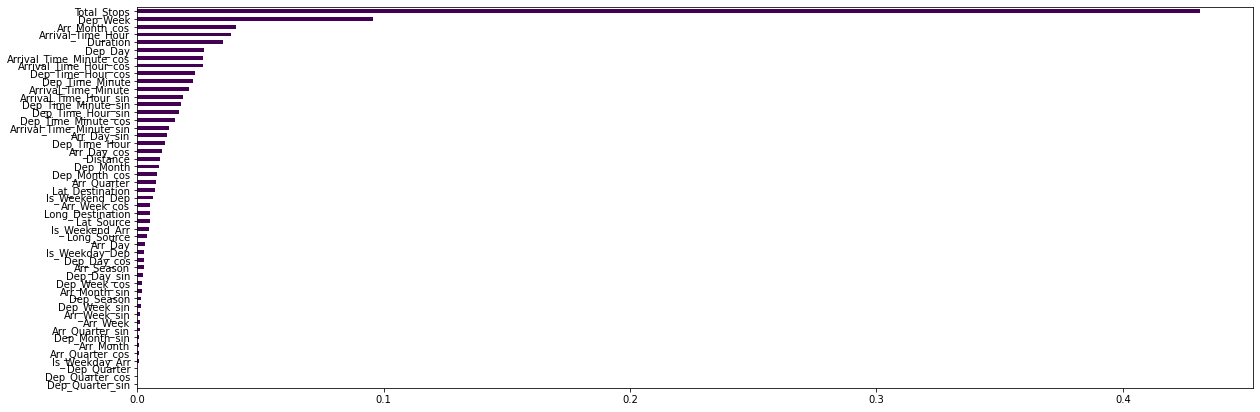

In [207]:
plt.figure(figsize=(20, 7))
feat_importances.sort_values(ascending=True).plot(kind='barh', cmap='viridis')
plt.show()

In [208]:
formula = 'Price ~ Duration + Total_Stops + Dep_Day + Dep_Month + Dep_Time_Hour + Dep_Time_Minute + Arrival_Time_Hour + Arrival_Time_Minute + Arr_Day + Arr_Month'

lm = ols(formula=formula, data=numerical_columns).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     768.3
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:39:01   Log-Likelihood:            -1.0238e+05
No. Observations:               10682   AIC:                         2.048e+05
Df Residuals:                   10671   BIC:                         2.049e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            9404.5366    

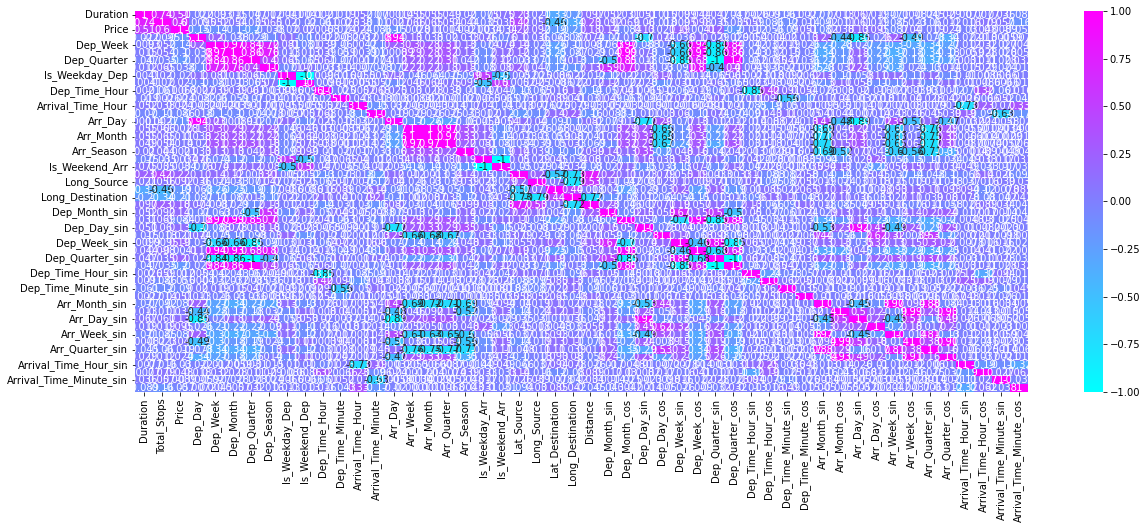

In [209]:
plt.figure(figsize=(20, 7))
sns.heatmap(numerical_columns.corr(), annot=True,cmap=plt.cm.cool)
plt.show()

In [210]:
merged_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Dep_Date,Dep_Day,Dep_Week,Dep_Month,Dep_Quarter,Dep_WeekName,Dep_Season,Is_Weekday_Dep,Is_Weekend_Dep,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Arrival_Date,Arr_Day,Arr_Week,Arr_Month,Arr_Quarter,Arr_WeekName,Arr_Season,Is_Weekday_Arr,Is_Weekend_Arr,Dep_Type_of_Day,Arr_Type_of_Day,Flight_Dep_Type,...,City4,City5,City6,Lat_Source,Long_Source,Lat_Destination,Long_Destination,Distance,holiday,holiday_type,Dep_Month_sin,Dep_Month_cos,Dep_Day_sin,Dep_Day_cos,Dep_Week_sin,Dep_Week_cos,Dep_Quarter_sin,Dep_Quarter_cos,Dep_Time_Hour_sin,Dep_Time_Hour_cos,Dep_Time_Minute_sin,Dep_Time_Minute_cos,Arr_Month_sin,Arr_Month_cos,Arr_Day_sin,Arr_Day_cos,Arr_Week_sin,Arr_Week_cos,Arr_Quarter_sin,Arr_Quarter_cos,Arrival_Time_Hour_sin,Arrival_Time_Hour_cos,Arrival_Time_Minute_sin,Arrival_Time_Minute_cos
0,IndiGo,2019-03-24,Banglore,New Delhi,"[BLR , DEL]",170,0,Null,3897,2019-03-24 22:20:00,24,12,3,1,Sunday,2,0,1,22,20,1,10,2019-03-25 01:10:00,25,13,3,1,Monday,2,1,0,Night,Late Night,IndiGo_Night,...,None,None,None,12.977063,77.587106,28.600000,77.200000,1737.653224,No Holiday,None,1.224647e-16,-1.0,-0.642788,0.766044,0.239316,-0.970942,1.224647e-16,-1.0,-0.269797,0.962917,0.755750,-0.654861,1.000000e+00,6.123234e-17,-0.762162,0.647386,9.953791e-01,-0.096023,1.000000e+00,6.123234e-17,2.697968e-01,0.962917,0.909632,0.415415
1,Air India,2019-05-01,Kolkata,Banglore,"[CCU , IXR , BBI , BLR]",445,2,Null,7662,2019-01-05 05:50:00,1,18,5,2,Wednesday,2,1,0,5,50,13,15,2019-01-05 13:15:00,5,1,1,1,Saturday,1,0,1,Early Morning,Afternoon,Air India_Early Morning,...,BLR,None,None,11.248016,75.780402,12.977063,77.587106,274.851302,No Holiday,None,-8.660254e-01,0.5,0.230616,0.973045,-0.935016,-0.354605,-2.449294e-16,1.0,0.979084,0.203456,-0.540641,0.841254,5.000000e-01,8.660254e-01,0.883512,0.468408,1.278772e-01,0.991790,1.000000e+00,6.123234e-17,-3.984011e-01,-0.917211,0.989821,-0.142315
2,Jet Airways,2019-06-09,Delhi,Cochin,"[DEL , LKO , BOM , COK]",1140,2,Null,13882,2019-09-06 09:25:00,9,23,6,2,Sunday,3,0,1,9,25,4,25,2019-09-07 04:25:00,7,36,9,3,Saturday,4,0,1,Morning,Early Morning,Jet Airways_Morning,...,COK,None,None,28.651952,77.231495,9.947743,76.253802,2082.311722,No Holiday,None,-2.449294e-16,1.0,0.866025,-0.500000,-0.663123,0.748511,-2.449294e-16,1.0,0.631088,-0.775711,0.281733,-0.959493,-1.000000e+00,-1.836970e-16,0.998533,0.054139,-9.953791e-01,-0.096023,-1.000000e+00,-1.836970e-16,8.878852e-01,0.460065,0.281733,-0.959493
3,IndiGo,2019-05-12,Kolkata,Banglore,"[CCU , NAG , BLR]",325,1,Null,6218,2019-12-05 18:05:00,12,19,5,2,Sunday,2,0,1,18,5,23,30,2019-12-05 23:30:00,5,49,12,4,Thursday,1,1,0,Evening,Night,IndiGo_Evening,...,None,None,None,11.248016,75.780402,12.977063,77.587106,274.851302,No Holiday,None,-8.660254e-01,0.5,0.342020,-0.939693,-0.992709,-0.120537,-2.449294e-16,1.0,-0.979084,0.203456,0.540641,0.841254,-2.449294e-16,1.000000e+00,0.883512,0.468408,-2.449294e-16,1.000000,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,-0.281733,-0.959493
4,IndiGo,2019-03-01,Banglore,New Delhi,"[BLR , NAG , DEL]",285,1,Null,13302,2019-01-03 16:50:00,1,9,3,1,Friday,2,1,0,16,50,21,35,2019-01-03 21:35:00,3,1,1,1,Thursday,1,1,0,Afternoon,Night,IndiGo_Afternoon,...,None,None,None,12.977063,77.587106,28.600000,77.200000,1737.653224,Swami Dayananda Saraswati Jayanti (R),Restricted,1.224647e-16,-1.0,0.230616,0.973045,0.822984,-0.568065,1.224647e-16,-1.0,-0.942261,-0.334880,-0.540641,0.841254,5.000000e-01,8.660254e-01,0.605174,0.796093,1.278772e-01,0.991790,1.000000e+00,6.123234e-17,-5.195840e-01,0.854419,-0.755750,-0.654861


In [103]:
merged_df.to_csv('final_frame_1.csv', index=False)

In [211]:
categorical_columns.head()

,Airline,Source,Destination,Route,Additional_Info,Dep_WeekName,Arr_WeekName,Dep_Type_of_Day,Arr_Type_of_Day,Flight_Dep_Type,Flight_Arr_Type,City1,City2,City3,City4,City5,City6,holiday,holiday_type
0,IndiGo,Banglore,New Delhi,"[BLR , DEL]",Null,Sunday,Monday,Night,Late Night,IndiGo_Night,IndiGo_Late Night,BLR,DEL,None,None,None,None,No Holiday,None
1,Air India,Kolkata,Banglore,"[CCU , IXR , BBI , BLR]",Null,Wednesday,Saturday,Early Morning,Afternoon,Air India_Early Morning,Air India_Afternoon,CCU,IXR,BBI,BLR,None,None,No Holiday,None
2,Jet Airways,Delhi,Cochin,"[DEL , LKO , BOM , COK]",Null,Sunday,Saturday,Morning,Early Morning,Jet Airways_Morning,Jet Airways_Early Morning,DEL,LKO,BOM,COK,None,None,No Holiday,None
3,IndiGo,Kolkata,Banglore,"[CCU , NAG , BLR]",Null,Sunday,Thursday,Evening,Night,IndiGo_Evening,IndiGo_Night,CCU,NAG,BLR,None,None,None,No Holiday,None
4,IndiGo,Banglore,New Delhi,"[BLR , NAG , DEL]",Null,Friday,Thursday,Afternoon,Night,IndiGo_Afternoon,IndiGo_Night,BLR,NAG,DEL,None,None,None,Swami Dayananda Saraswati Jayanti (R),Restricted


In [105]:
columns = ['Dep_WeekName', 'Arr_WeekName', 'Dep_Type_of_Day', 'Arr_Type_of_Day', 'Additional_Info', 'City1', 'City2', 'City3', 'City4', 'City5', 'City6', 'holiday', 'holiday_type']
for col in columns:
    le = LabelEncoder()
    merged_df.loc[:, col] = le.fit_transform(merged_df[col])

In [106]:
features = ['Airline', 'Source', 'Destination', 'Flight_Dep_Type', 'Flight_Arr_Type']
merged_df = pd.get_dummies(data=merged_df, columns=features)

In [107]:
merged_df.head()

,Date_of_Journey,Route,Duration,Total_Stops,Additional_Info,Price,Dep_Date,Dep_Day,Dep_Week,Dep_Month,Dep_Quarter,Dep_WeekName,Dep_Season,Is_Weekday_Dep,Is_Weekend_Dep,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Arrival_Date,Arr_Day,Arr_Week,Arr_Month,Arr_Quarter,Arr_WeekName,Arr_Season,Is_Weekday_Arr,Is_Weekend_Arr,Dep_Type_of_Day,Arr_Type_of_Day,City1,City2,City3,City4,...,Flight_Arr_Type_IndiGo_Late Night,Flight_Arr_Type_IndiGo_Morning,Flight_Arr_Type_IndiGo_Night,Flight_Arr_Type_Jet Airways Business_Afternoon,Flight_Arr_Type_Jet Airways Business_Early Morning,Flight_Arr_Type_Jet Airways Business_Morning,Flight_Arr_Type_Jet Airways_Afternoon,Flight_Arr_Type_Jet Airways_Early Morning,Flight_Arr_Type_Jet Airways_Evening,Flight_Arr_Type_Jet Airways_Morning,Flight_Arr_Type_Jet Airways_Night,Flight_Arr_Type_Multiple carriers Premium economy_Afternoon,Flight_Arr_Type_Multiple carriers Premium economy_Evening,Flight_Arr_Type_Multiple carriers Premium economy_Late Night,Flight_Arr_Type_Multiple carriers Premium economy_Night,Flight_Arr_Type_Multiple carriers_Afternoon,Flight_Arr_Type_Multiple carriers_Early Morning,Flight_Arr_Type_Multiple carriers_Evening,Flight_Arr_Type_Multiple carriers_Late Night,Flight_Arr_Type_Multiple carriers_Morning,Flight_Arr_Type_Multiple carriers_Night,Flight_Arr_Type_SpiceJet_Afternoon,Flight_Arr_Type_SpiceJet_Early Morning,Flight_Arr_Type_SpiceJet_Evening,Flight_Arr_Type_SpiceJet_Morning,Flight_Arr_Type_SpiceJet_Night,Flight_Arr_Type_Trujet_Afternoon,Flight_Arr_Type_Vistara Premium economy_Afternoon,Flight_Arr_Type_Vistara Premium economy_Evening,Flight_Arr_Type_Vistara Premium economy_Morning,Flight_Arr_Type_Vistara_Afternoon,Flight_Arr_Type_Vistara_Evening,Flight_Arr_Type_Vistara_Morning,Flight_Arr_Type_Vistara_Night
0,2019-03-24,"[BLR , DEL]",170,0,8,3897,2019-03-24 22:20:00,24,12,3,1,3,2,0,1,22,20,1,10,2019-03-25 01:10:00,25,13,3,1,1,2,1,0,5,3,0,13,29,13,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-05-01,"[CCU , IXR , BBI , BLR]",445,2,7,7662,2019-01-05 05:50:00,1,18,5,2,6,2,1,0,5,50,13,15,2019-01-05 13:15:00,5,1,1,1,2,1,0,1,1,0,2,25,1,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-06-09,"[DEL , LKO , BOM , COK]",1140,2,7,13882,2019-09-06 09:25:00,9,23,6,2,3,3,0,1,9,25,4,25,2019-09-07 04:25:00,7,36,9,3,2,4,0,1,4,1,3,32,4,5,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-05-12,"[CCU , NAG , BLR]",325,1,7,6218,2019-12-05 18:05:00,12,19,5,2,3,2,0,1,18,5,23,30,2019-12-05 23:30:00,5,49,12,4,4,1,1,0,2,5,2,34,3,13,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-03-01,"[BLR , NAG , DEL]",285,1,7,13302,2019-01-03 16:50:00,1,9,3,1,0,2,1,0,16,50,21,35,2019-01-03 21:35:00,3,1,1,1,4,1,1,0,0,5,0,34,8,13,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [108]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Columns: 198 entries, Date_of_Journey to Flight_Arr_Type_Vistara_Night
dtypes: datetime64[ns](3), float64(29), int32(13), int64(21), object(1), uint8(131)
memory usage: 6.3+ MB


In [109]:
datetime_and_object = [col for col in merged_df.columns if merged_df[col].dtypes in ['datetime64[ns]', 'object']]
datetime_and_object

['Date_of_Journey', 'Route', 'Dep_Date', 'Arrival_Date']

In [110]:
datetime_and_object_df = merged_df[datetime_and_object]
datetime_and_object_df

,Date_of_Journey,Route,Dep_Date,Arrival_Date
0,2019-03-24,"[BLR , DEL]",2019-03-24 22:20:00,2019-03-25 01:10:00
1,2019-05-01,"[CCU , IXR , BBI , BLR]",2019-01-05 05:50:00,2019-01-05 13:15:00
2,2019-06-09,"[DEL , LKO , BOM , COK]",2019-09-06 09:25:00,2019-09-07 04:25:00
3,2019-05-12,"[CCU , NAG , BLR]",2019-12-05 18:05:00,2019-12-05 23:30:00
4,2019-03-01,"[BLR , NAG , DEL]",2019-01-03 16:50:00,2019-01-03 21:35:00
...,...,...,...,...
10678,2019-04-09,"[CCU , BLR]",2019-09-04 19:55:00,2019-09-04 22:25:00
10679,2019-04-27,"[CCU , BLR]",2019-04-27 20:45:00,2019-04-27 23:20:00
10680,2019-04-27,"[BLR , DEL]",2019-04-27 08:20:00,2019-04-27 11:20:00
10681,2019-03-01,"[BLR , DEL]",2019-01-03 11:30:00,2019-01-03 14:10:00


In [52]:
merged_df.drop(['Date_of_Journey', 'Route', 'Dep_Date', 'Arrival_Date'], axis=1, inplace=True)

In [53]:
merged_df.head()

,Duration,Total_Stops,Additional_Info,Price,Dep_Day,Dep_Week,Dep_Month,Dep_Quarter,Dep_WeekName,Dep_Season,Is_Weekday_Dep,Is_Weekend_Dep,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Arr_Day,Arr_Week,Arr_Month,Arr_Quarter,Arr_WeekName,Arr_Season,Is_Weekday_Arr,Is_Weekend_Arr,Dep_Type_of_Day,Arr_Type_of_Day,City1,City2,City3,City4,City5,City6,Lat_Source,Long_Source,...,Flight_Arr_Type_IndiGo_Late Night,Flight_Arr_Type_IndiGo_Morning,Flight_Arr_Type_IndiGo_Night,Flight_Arr_Type_Jet Airways Business_Afternoon,Flight_Arr_Type_Jet Airways Business_Early Morning,Flight_Arr_Type_Jet Airways Business_Morning,Flight_Arr_Type_Jet Airways_Afternoon,Flight_Arr_Type_Jet Airways_Early Morning,Flight_Arr_Type_Jet Airways_Evening,Flight_Arr_Type_Jet Airways_Morning,Flight_Arr_Type_Jet Airways_Night,Flight_Arr_Type_Multiple carriers Premium economy_Afternoon,Flight_Arr_Type_Multiple carriers Premium economy_Evening,Flight_Arr_Type_Multiple carriers Premium economy_Late Night,Flight_Arr_Type_Multiple carriers Premium economy_Night,Flight_Arr_Type_Multiple carriers_Afternoon,Flight_Arr_Type_Multiple carriers_Early Morning,Flight_Arr_Type_Multiple carriers_Evening,Flight_Arr_Type_Multiple carriers_Late Night,Flight_Arr_Type_Multiple carriers_Morning,Flight_Arr_Type_Multiple carriers_Night,Flight_Arr_Type_SpiceJet_Afternoon,Flight_Arr_Type_SpiceJet_Early Morning,Flight_Arr_Type_SpiceJet_Evening,Flight_Arr_Type_SpiceJet_Morning,Flight_Arr_Type_SpiceJet_Night,Flight_Arr_Type_Trujet_Afternoon,Flight_Arr_Type_Vistara Premium economy_Afternoon,Flight_Arr_Type_Vistara Premium economy_Evening,Flight_Arr_Type_Vistara Premium economy_Morning,Flight_Arr_Type_Vistara_Afternoon,Flight_Arr_Type_Vistara_Evening,Flight_Arr_Type_Vistara_Morning,Flight_Arr_Type_Vistara_Night
0,170,0,8,3897,24,12,3,1,3,2,0,1,22,20,1,10,25,13,3,1,1,2,1,0,5,3,0,13,29,13,5,1,12.977063,77.587106,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,445,2,7,7662,1,18,5,2,6,2,1,0,5,50,13,15,5,1,1,1,2,1,0,1,1,0,2,25,1,3,5,1,11.248016,75.780402,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1140,2,7,13882,9,23,6,2,3,3,0,1,9,25,4,25,7,36,9,3,2,4,0,1,4,1,3,32,4,5,5,1,28.651952,77.231495,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,325,1,7,6218,12,19,5,2,3,2,0,1,18,5,23,30,5,49,12,4,4,1,1,0,2,5,2,34,3,13,5,1,11.248016,75.780402,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,285,1,7,13302,1,9,3,1,0,2,1,0,16,50,21,35,3,1,1,1,4,1,1,0,0,5,0,34,8,13,5,1,12.977063,77.587106,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
merged_df.to_csv('final.csv', index = False)

In [597]:
X = merged_df.drop('Price', axis=1)
Y = merged_df['Price']

X = sm.add_constant(X)

lm = sm.OLS(Y, X)
lm_fit = lm.fit()
print(lm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     239.4
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:05:18   Log-Likelihood:                -97577.
No. Observations:               10682   AIC:                         1.954e+05
Df Residuals:                   10539   BIC:                         1.965e+05
Df Model:                         142                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [598]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = merged_df.drop('Price', axis=1)

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Columns'] = X.columns
vif_info['VIF'] = np.round(vif_info['VIF'], 3)
vif_info.sort_values('VIF', ascending=False)

,VIF,Columns
96,inf,Flight_Dep_Type_GoAir_Afternoon
97,inf,Flight_Dep_Type_GoAir_Early Morning
123,inf,Flight_Dep_Type_Multiple carriers_Morning
124,inf,Flight_Dep_Type_Multiple carriers_Night
125,inf,Flight_Dep_Type_SpiceJet_Afternoon
...,...,...
26,1.564,City2
19,1.530,Arr_WeekName
2,1.480,Additional_Info
49,1.373,Dep_Time_Minute_cos


In [606]:
pd.set_option('display.max_columns', 193)
vif_info.sort_values(by='VIF', ascending=False).T

,96,97,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,122,121,120,108,99,100,101,102,103,104,105,106,107,109,119,110,111,112,113,114,115,116,117,118,144,145,146,181,172,173,174,175,176,177,178,179,180,182,170,183,184,185,186,187,188,189,190,191,171,169,147,157,148,149,150,151,152,153,154,155,156,158,168,159,160,161,162,163,164,165,166,167,98,192,5,65,63,62,21,6,57,56,51,50,8,95,9,10,45,44,39,38,35,34,33,32,31,17,18,20,25,24,23,64,22,66,76,86,85,84,83,82,89,90,91,67,81,80,79,78,88,77,75,72,68,69,70,74,71,73,94,93,92,87,15,3,16,55,4,0,54,13,11,52,43,40,42,41,53,1,46,27,59,58,28,47,12,14,60,36,37,29,48,61,7,26,19,2,49,30
VIF,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,989690.99,918195.55,12851.087,2272.52,2100.309,1586.509,1191.945,1055.235,749.556,199.062,175.208,143.982,120.671,68.377,54.564,53.734,26.234,25.98,20.383,18.072,17.713,10.04,4.379,4.124,2.51,2.495,2.386,2.152,2.02,1.782,1.589,1.564,1.53,1.48,1.373,1.049
Columns,Flight_Dep_Type_GoAir_Afternoon,Flight_Dep_Type_GoAir_Early Morning,Flight_Dep_Type_Multiple carriers_Morning,Flight_Dep_Type_Multiple carriers_Night,Flight_Dep_Type_SpiceJet_Afternoon,Flight_Dep_Type_SpiceJet_Early Morning,Flight_Dep_Type_SpiceJet_Evening,Flight_Dep_Type_SpiceJet_Morning,Flight_Dep_Type_SpiceJet_Night,Flight_Dep_Type_Trujet_Afternoon,Flight_Dep_Type_Vistara Premium economy_Afternoon,Flight_Dep_Type_Vistara Premium economy_Early ...,Flight_Dep_Type_Vistara Premium economy_Morning,Flight_Dep_Type_Vistara_Afternoon,Flight_Dep_Type_Vistara_Early Morning,Flight_Dep_Type_Vistara_Evening,Flight_Dep_Type_Vistara_Morning,Flight_Dep_Type_Vistara_Night,Flight_Arr_Type_Air Asia_Afternoon,Flight_Arr_Type_Air Asia_Early Morning,Flight_Arr_Type_Air Asia_Evening,Flight_Arr_Type_Air Asia_Late Night,Flight_Arr_Type_Air Asia_Morning,Flight_Dep_Type_Multiple carriers_Late Night,Flight_Dep_Type_Multiple carriers_Evening,Flight_Dep_Type_Multiple carriers_Early Morning,Flight_Dep_Type_Jet Airways Business_Evening,Flight_Dep_Type_GoAir_Morning,Flight_Dep_Type_GoAir_Night,Flight_Dep_Type_IndiGo_Afternoon,Flight_Dep_Type_IndiGo_Early Morning,Flight_Dep_Type_IndiGo_Evening,Flight_Dep_Type_IndiGo_Late Night,Flight_Dep_Type_IndiGo_Morning,Flight_Dep_Type_IndiGo_Night,Flight_Dep_Type_Jet Airways Business_Early Mor...,Flight_Dep_Type_Jet Airways Business_Morning,Flight_Dep_Type_Multiple carriers_Afternoon,Flight_Dep_Type_Jet Airways_Afternoon,Flight_Dep_Type_Jet Airways_Early Morning,Flight_Dep_Type_Jet Airways_Evening,Flight_Dep_Type_Jet Airways_Late Night,Flight_Dep_Type_Jet Airways_Morning,Flight_Dep_Type_Jet Airways_Night,Flight_Dep_Type_Multiple carriers Premium econ...,Flight_Dep_Type_Multiple carriers Premium econ...,Flight_Dep_Type_Multiple carriers Premium econ...,Flight_Arr_Type_Air Asia_Night,Flight_Arr_Type_Air India_Afternoon,Flight_Arr_Type_Air India_Early Morning,Flight_Arr_Type_SpiceJet_Early Morning,Flight_Arr_Type_Multiple carriers Premium econ...,Flight_Arr_Type_Multiple carriers Premium econ...,Flight_Arr_Type_Multiple carriers_Afternoon,Flight_Arr_Type_Multiple carriers_Early Morning,Flight_Arr_Type_Multiple carriers_Evening,Flight_Arr_Type_Multiple carriers_Late Night,Flight_Arr_Type_Multiple carriers_Morning,Flight_Arr_Type_Multiple carriers_Night,Flight_Arr_Type_SpiceJet_Afternoon,Flight_Arr_Type_SpiceJet_Evening,Flight_Arr_Type_Multiple carriers Premium econ...,Flight_Arr_Type_SpiceJet_M

In [605]:
X.drop('Arr_Day', axis=1, inplace=True)

In [609]:
X.drop('Arr_Week', axis=1, inplace=True)

In [613]:
X.drop('Dep_Week', axis=1, inplace=True)

In [616]:
X.drop('Arr_Week_cos', axis=1, inplace=True)

In [619]:
X.drop('Arr_Week_sin', axis=1, inplace=True)

In [622]:
X.drop('Arr_Day_sin', axis=1, inplace=True)

In [625]:
X.drop('Dep_Week_cos', axis=1, inplace=True)

In [628]:
X.drop('Dep_Day_cos', axis=1, inplace=True)

In [631]:
X.drop('Total_Stops', axis=1, inplace=True)

In [634]:
X.drop('Dep_Time_Hour_sin', axis=1, inplace=True)

In [637]:
X.drop('Arrival_Time_Hour_cos', axis=1, inplace=True)

In [640]:
X.drop('Arrival_Time_Hour_sin', axis=1, inplace=True)

In [643]:
X.drop('Dep_Week_sin', axis=1, inplace=True)

In [646]:
X.drop('Dep_Time_Hour', axis=1, inplace=True)

In [649]:
X.drop('Arrival_Time_Hour', axis=1, inplace=True)

In [652]:
X.drop('Dep_Time_Hour_cos', axis=1, inplace=True)

In [655]:
X.drop('Dep_Day_sin', axis=1, inplace=True)

In [656]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Columns'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Columns
88,inf,Flight_Dep_Type_IndiGo_Morning
121,inf,Flight_Dep_Type_Vistara_Night
113,inf,Flight_Dep_Type_Trujet_Afternoon
114,inf,Flight_Dep_Type_Vistara Premium economy_Afternoon
115,inf,Flight_Dep_Type_Vistara Premium economy_Early ...
...,...,...
37,1.361693,Dep_Time_Minute_cos
5,1.341918,Dep_WeekName
13,1.199427,Arr_WeekName
23,1.085441,City5


In [657]:
pd.set_option('display.max_columns', 192)
vif_info.sort_values(by='VIF', ascending=False).T

,88,121,113,114,115,116,117,118,119,120,122,111,123,124,125,126,127,128,129,130,112,110,132,99,91,92,93,94,95,96,97,98,100,109,101,102,103,104,105,106,107,108,131,133,89,165,157,158,159,160,161,162,163,164,166,155,167,168,169,170,171,172,173,174,156,154,134,143,135,136,137,138,139,140,141,142,144,153,145,146,147,148,149,150,151,152,90,175,49,42,34,35,3,38,39,41,87,32,45,46,47,48,50,51,33,4,53,19,12,14,15,16,17,18,8,29,7,6,25,26,27,28,52,11,54,81,79,82,78,77,76,75,74,73,72,71,55,70,69,68,67,83,66,56,86,57,58,59,60,61,85,62,63,84,64,65,80,21,0,10,43,2,9,22,36,31,44,30,20,40,1,37,5,13,23,24
VIF,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,4.739268,2.873736,2.503187,2.367401,2.153733,2.124688,1.952826,1.94952,1.867175,1.715148,1.570619,1.532024,1.502447,1.466761,1.361693,1.341918,1.199427,1.085441,1.01068
Columns,Flight_Dep_Type_IndiGo_Morning,Flight_Dep_Type_Vistara_Night,Flight_Dep_Type_Trujet_Afternoon,Flight_Dep_Type_Vistara Premium economy_Afternoon,Flight_Dep_Type_Vistara Premium economy_Early ...,Flight_Dep_Type_Vistara Premium economy_Morning,Flight_Dep_Type_Vistara_Afternoon,Flight_Dep_Type_Vistara_Early Morning,Flight_Dep_Type_Vistara_Evening,Flight_Dep_Type_Vistara_Morning,Flight_Arr_Type_Air Asia_Afternoon,Flight_Dep_Type_SpiceJet_Morning,Flight_Arr_Type_Air Asia_Early Morning,Flight_Arr_Type_Air Asia_Evening,Flight_Arr_Type_Air Asia_Late Night,Flight_Arr_Type_Air Asia_Morning,Flight_Arr_Type_Air Asia_Night,Flight_Arr_Type_Air India_Afternoon,Flight_Arr_Type_Air India_Early Morning,Flight_Arr_Type_Air India_Evening,Flight_Dep_Type_SpiceJet_Night,Flight_Dep_Type_SpiceJet_Evening,Flight_Arr_Type_Air India_Morning,Flight_Dep_Type_Multiple carriers Premium econ...,Flight_Dep_Type_Jet Airways Business_Evening,Flight_Dep_Type_Jet Airways Business_Morning,Flight_Dep_Type_Jet Airways_Afternoon,Flight_Dep_Type_Jet Airways_Early Morning,Flight_Dep_Type_Jet Airways_Evening,Flight_Dep_Type_Jet Airways_Late Night,Flight_Dep_Type_Jet Airways_Morning,Flight_Dep_Type_Jet Airways_Night,Flight_Dep_Type_Multiple carriers Premium econ...,Flight_Dep_Type_SpiceJet_Early Morning,Flight_Dep_Type_Multiple carriers Premium econ...,Flight_Dep_Type_Multiple carriers_Afternoon,Flight_Dep_Type_Multiple carriers_Early Morning,Flight_Dep_Type_Multiple carriers_Evening,Flight_Dep_Type_Multiple carriers_Late Night,Flight_Dep_Type_Multiple carriers_Morning,Flight_Dep_Type_Multiple carriers_Night,Flight_Dep_Type_SpiceJet_Afternoon,Flight_Arr_Type_Air India_Late Night,Flight_Arr_Type_Air India_Night,Flight_Dep_Type_IndiGo_Night,Flight_Arr_Type_SpiceJet_Evening,Flight_Arr_Type_Multiple carriers_Afternoon,Flight_Arr_Type_Multiple carriers_Early Morning,Flight_Arr_Type_Multiple carriers_Evening,Flight_Arr_Type_Multiple carriers_Late Night,Flight_Arr_Type_Multiple carriers_Morning,Flight_Arr_Type_Multiple carriers_Night,Flight_Arr_Type_SpiceJet_Afternoon,Flight_Arr_Type_SpiceJet_Early Morning,Flight_Arr_Type_SpiceJet_Morning,Flight_Arr_Type_Multiple carriers Premium econ...,Flight_Arr_Type_SpiceJet_Night,Flight_Arr_Type_Trujet_Afternoon,Flight_Arr_Type_Vistara Premium economy_Afternoon,Flight_Arr_Type_Vistara Premium economy_Evening,Flight_Arr_Type_Vistara Premium economy_Morning,Flight_Arr_Type_Vistara_Afternoon,Flight_Arr_Type_Vistara_Evening,Flight_Arr_Type_Vistara_Morning,Flight_Arr_Type_Multiple carriers Premium econ...,Flight_Arr_Type_Multiple carriers Premium econ...,Flight_Arr_Ty

In [658]:
X = merged_df.drop(['Arr_Day', 'Arr_Week', 'Dep_Week', 'Arr_Week_cos', 'Arr_Week_sin', 'Arr_Day_sin', 'Dep_Week_cos', 'Dep_Day_cos', 'Total_Stops', 'Dep_Time_Hour_sin', 'Arrival_Time_Hour_cos', 'Arrival_Time_Hour_sin', 'Dep_Week_sin', 'Dep_Time_Hour', 'Arrival_Time_Hour', 'Dep_Time_Hour_cos', 'Dep_Day_sin', 'Price'], axis=1)
Y = merged_df['Price']

X = sm.add_constant(X)

lm = sm.OLS(Y, X)
lm_fit = lm.fit()
print(lm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     237.6
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:38:16   Log-Likelihood:                -98124.
No. Observations:               10682   AIC:                         1.965e+05
Df Residuals:                   10556   BIC:                         1.974e+05
Df Model:                         125                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------